<h1>Random Forest Population Density Prediction</h1>

<h4>Sources</h4>

NASA Population Density:
    Center for International Earth Science Information Network - CIESIN - Columbia University. 2018. Gridded Population of the World, Version 4 (GPWv4): Population Density, Revision 11. Palisades, New York: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H49C6VHW.

NDVI:
    Pinzon, J.E., E.W. Pak, C.J. Tucker, U.S. Bhatt, G.V. Frost, and M.J. Macander. 2023. Global Vegetation Greenness (NDVI) from AVHRR GIMMS-3G+, 1981-2022. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2187

Annual Rainfall:
    Brust, Colin. Montana Climate Normals, Montana Climate Office, data.climate.umt.edu/mt-normals/cog/. Accessed 13 Nov. 2024. 

Annual Temperature:
    Brust, Colin. Montana Climate Normals, Montana Climate Office, data.climate.umt.edu/mt-normals/cog/. Accessed 13 Nov. 2024. 

Principal Aquifers of Montana:
    The Montana Bureau of Mines and Geology (MBMG). (n.d.). Water resources. GIS Data Hub Site. https://gis-data-hub-mbmg.hub.arcgis.com/pages/water-resources

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as xrio
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# np.set_printoptions(linewidth=200)

<h1>Data<h1>

note: All of these data sources were scaled down and clipped in qgis. Consistent resolution following this should be about 1km per grid square. All are also EPSG 4269.

Annual Rainfall (mm)

In [41]:
rain_data = xrio.open_rasterio("data2\\annual_rain.tif")

print(rain_data)
rain_data

<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
[32256 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        2824.7434082031
    STATISTICS_MEAN:           498.79483239204
    STATISTICS_MINIMUM:        163.73666381836
    STATISTICS_STDDEV:         271.78600853487
    STATISTICS_VALID_PERCENT:  81.55
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0


<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
[32256 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        2824.7434082031
    STATISTICS_MEAN:           498.79483239204
    STATISTICS_MINIMUM:        163.73666381836
    STATISTICS_STDDEV:         271.78600853487
    STATISTICS_VALID_PERCENT:  81.55
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0

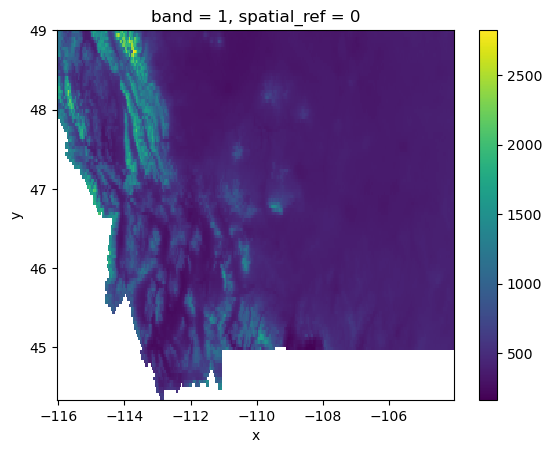

In [42]:
rain_data.plot()

Annual Avg Temperature (K)... later plotted as F

In [43]:
tmin_data = xrio.open_rasterio("data2\\annual_tmin.tif")
print(tmin_data)
# tmin_data

tmax_data = xrio.open_rasterio("data2\\annual_tmin.tif")
print(tmax_data)
# tmax_data

<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
[32256 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        276.67013549805
    STATISTICS_MEAN:           272.32652699707
    STATISTICS_MINIMUM:        263.47247314453
    STATISTICS_STDDEV:         1.4713366231669
    STATISTICS_VALID_PERCENT:  81.53
    _FillValue:                nan
    scale_factor:              1.0
    add_offset:                0.0
<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
[32256 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
  

In [44]:
#K to F
data_fahrenheit_min = (tmin_data - 273.15) * 9/5 + 32

data_fahrenheit_min.attrs = tmin_data.attrs
data_fahrenheit_min.attrs['units'] = 'Fahrenheit'

# data_fahrenheit_min


data_fahrenheit_max = (tmax_data - 273.15) * 9/5 + 32

data_fahrenheit_max.attrs = tmax_data.attrs
data_fahrenheit_max.attrs['units'] = 'Fahrenheit'

# data_fahrenheit_max

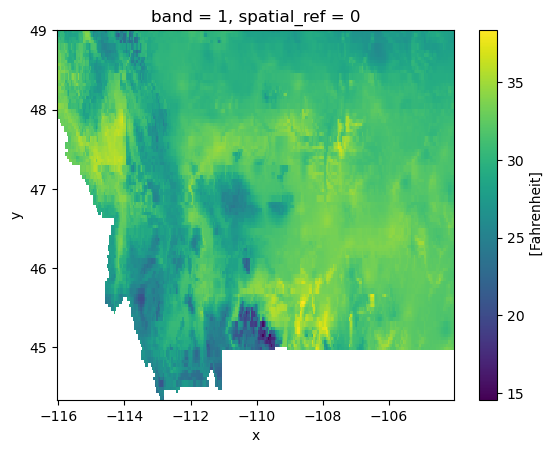

In [45]:
data_fahrenheit_max.plot()

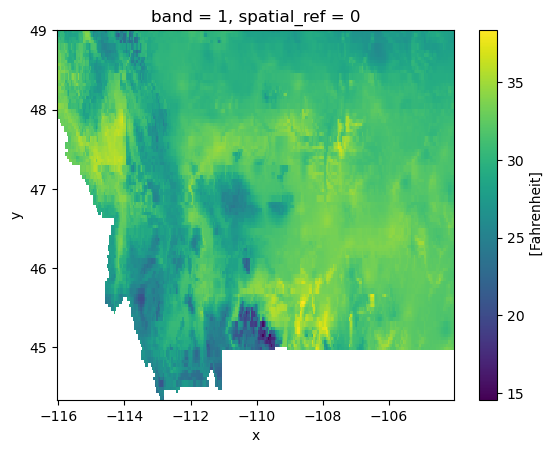

In [46]:
data_fahrenheit_min.plot()

In [47]:
#combining max and min
tcomb_data = (data_fahrenheit_min + data_fahrenheit_max)/2
tcomb_data

<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
array([[[30.287395, 29.181732, 29.8146  , ..., 27.95725 , 27.870295,
         27.825085],
        [29.936987, 28.976452, 30.360235, ..., 27.847279, 27.77658 ,
         27.727636],
        [30.298054, 30.198406, 29.884144, ..., 27.7651  , 27.68847 ,
         27.631725],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
    spatial_ref  int64 8B 0

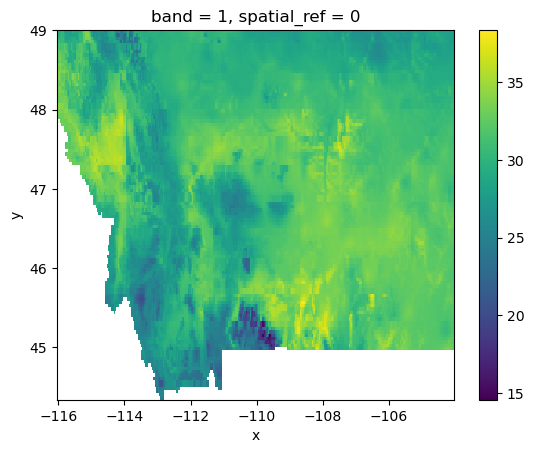

In [48]:
tcomb_data.plot()

ndvi

In [49]:
ndvi_data = xrio.open_rasterio("data2\\ndvi_final.tif")

print(ndvi_data)
ndvi_data

<xarray.DataArray (band: 1, y: 110, x: 288)> Size: 127kB
[31680 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 880B 48.94 48.9 48.86 48.82 ... 44.48 44.44 44.4
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        0.42800000309944
    STATISTICS_MEAN:           0.073344168064892
    STATISTICS_MINIMUM:        -0.59200000762939
    STATISTICS_STDDEV:         0.31341878736657
    STATISTICS_VALID_PERCENT:  80.02
    _FillValue:                -3.4028235e+38
    scale_factor:              1.0
    add_offset:                0.0


<xarray.DataArray (band: 1, y: 110, x: 288)> Size: 127kB
[31680 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 880B 48.94 48.9 48.86 48.82 ... 44.48 44.44 44.4
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        0.42800000309944
    STATISTICS_MEAN:           0.073344168064892
    STATISTICS_MINIMUM:        -0.59200000762939
    STATISTICS_STDDEV:         0.31341878736657
    STATISTICS_VALID_PERCENT:  80.02
    _FillValue:                -3.4028235e+38
    scale_factor:              1.0
    add_offset:                0.0

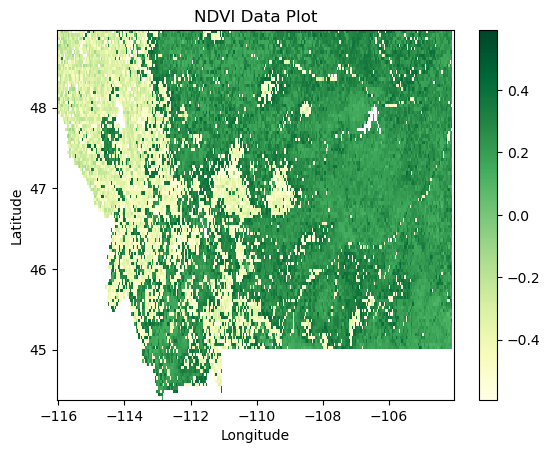

In [50]:
import matplotlib.pyplot as plt
import numpy as np

ndvi_data = ndvi_data.where(ndvi_data != ndvi_data.attrs['_FillValue'], np.nan)

ndvi_data.plot(x='x', y='y', cmap='YlGn')
plt.title("NDVI Data Plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

population density (part 1)

In [51]:
pop_data = xrio.open_rasterio("data2\popdens.tif")

print(pop_data)
pop_data

<xarray.DataArray (band: 1, y: 111, x: 288)> Size: 128kB
[31968 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 888B 48.98 48.94 48.9 48.85 ... 44.48 44.44 44.4
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_MAXIMUM:        1804.8670654297
    STATISTICS_MEAN:           2.9575220193198
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         34.230102647606
    STATISTICS_VALID_PERCENT:  81.25
    _FillValue:                -3.402823e+38
    scale_factor:              1.0
    add_offset:                0.0


<xarray.DataArray (band: 1, y: 111, x: 288)> Size: 128kB
[31968 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 888B 48.98 48.94 48.9 48.85 ... 44.48 44.44 44.4
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_MAXIMUM:        1804.8670654297
    STATISTICS_MEAN:           2.9575220193198
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         34.230102647606
    STATISTICS_VALID_PERCENT:  81.25
    _FillValue:                -3.402823e+38
    scale_factor:              1.0
    add_offset:                0.0

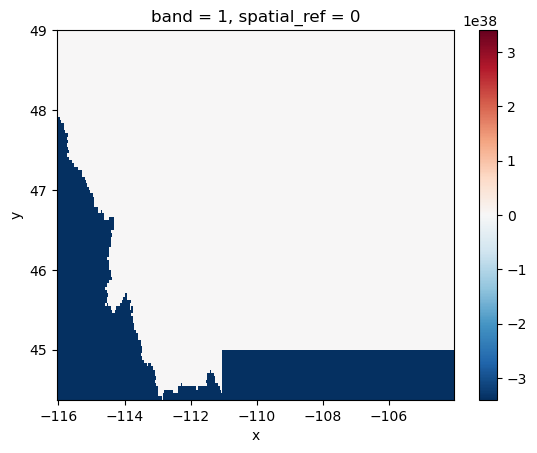

In [52]:
pop_data.plot()

<h2>View 1: Random Forest Regression 1<h2>

In [53]:
#print shapes
print("NDVI Shape:", ndvi_data.shape)
print("Tcomb Shape:", tcomb_data.shape)
print("Rain Shape:", rain_data.shape)
print("Population Data Shape:", pop_data.shape)

NDVI Shape: (1, 110, 288)
Tcomb Shape: (1, 112, 288)
Rain Shape: (1, 112, 288)
Population Data Shape: (1, 111, 288)


In [54]:
#match tcomb dims
target_shape = tcomb_data.shape

ndvi_data_resampled = ndvi_data.interp(y=tcomb_data.coords['y'])
pop_data_resampled = pop_data.interp(y=tcomb_data.coords['y'])
rain_data_resampled = rain_data.interp(y=tcomb_data.coords['y'])

In [55]:
#verify shapes
print("Resampled NDVI Shape:", ndvi_data_resampled.shape)
print("Resampled Population Shape:", pop_data_resampled.shape)
print("Resampled Rain Shape:", rain_data_resampled.shape)
print("Tcomb Shape:", tcomb_data.shape)

Resampled NDVI Shape: (1, 112, 288)
Resampled Population Shape: (1, 112, 288)
Resampled Rain Shape: (1, 112, 288)
Tcomb Shape: (1, 112, 288)


In [56]:
#flatten inputs
X = np.stack([ndvi_data_resampled.values.flatten(), 
              tcomb_data.values.flatten(), 
              rain_data_resampled.values.flatten()], axis=1)

#flatten y
y = pop_data_resampled.values.flatten()

#remove NaN becuase they break regression
mask1 = ~np.isnan(y)
X_train = X[mask1]
y_train = y[mask1]

#ensure shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (31680, 3)
y_train shape: (31680,)


In [57]:
from sklearn.ensemble import RandomForestRegressor

#create the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

#train the model
model.fit(X_train, y_train)

#predict from training
y_pred = model.predict(X_train)


print("R^2 Score:", r2_score(y_train, y_pred))
print("Number of predictions:", len(y_pred))

R^2 Score: 0.9969589124088297
Number of predictions: 31680


In [58]:
#copy dims of log_p_dens
new_xarray = pop_data_resampled.copy()

#find not nan locations
non_nan_indices = np.where(~np.isnan(pop_data_resampled.values))

#assign seqentially through pred since it follows orig pattern
new_xarray.values[non_nan_indices] = y_pred

print(new_xarray)

<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 258kB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 1.48451330e+00,  4.40252717e-01,  1.00890007e+00, ...,
          2.26526353e+00,  2.42044178e+00, -3.40282306e+36],
        [ 1.04332782e+00,  1.44495103e+00,  1.13256947e+00, ...,
          2.27222499e+00,  2.32057510e+00, -1.25904453e+37],
        ...,
        [-3.39894778e+38, -3.39894778e+38, -3.39894778e+38, ...,
         -3.39894778e+38, -3.39894778e+38, -3.39894778e+38],
        [-3.39894778e+38, -3.39894778e+38, -3.39894778e+38, ...,
         -3.39894778e+38, -3.39894778e+38, -3.39894778e+38],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
    spatial_ref  int64 8B 0
  * y            

R^2 Score: 0.9969589124088297
Number of predictions: 31680


Text(0.5, 1.0, 'Predicted Population Density')

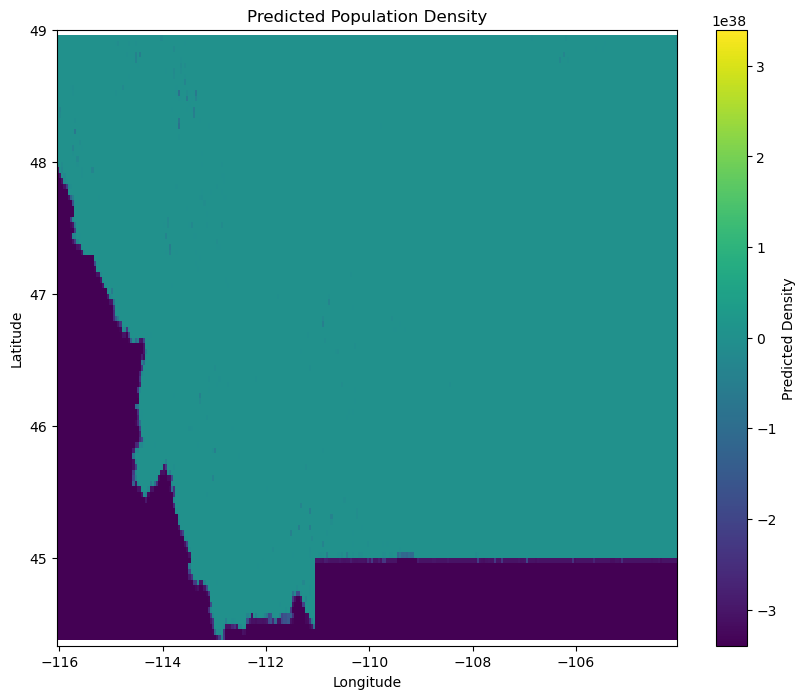

In [59]:
print("R^2 Score:", r2_score(y_train, y_pred))
print("Number of predictions:", len(y_pred))

ax = new_xarray.plot(
    cmap='viridis',
    figsize=(10, 8),
    cbar_kwargs={'label': 'Predicted Density'},
    # robust=True,
    add_colorbar=True,
)

ax = plt.gca()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Predicted Population Density')

Comments: This looks almost completely unusable. Going to take the log of population instead. Upside is that a prediction was made. I do like that latitude and longitude are displayed as well. As far as views go this isn't really usable from a visual side, but data wise I have enough to work with.

<h2>View 2: Random Forest Regression 2</h2>

population density pt 2.

c:\Users\aster\anaconda3\envs\geo-nb\Lib\site-packages\xarray\core\computation.py:818: RuntimeWarning: invalid value encountered in log1p
  result_data = func(*input_data)


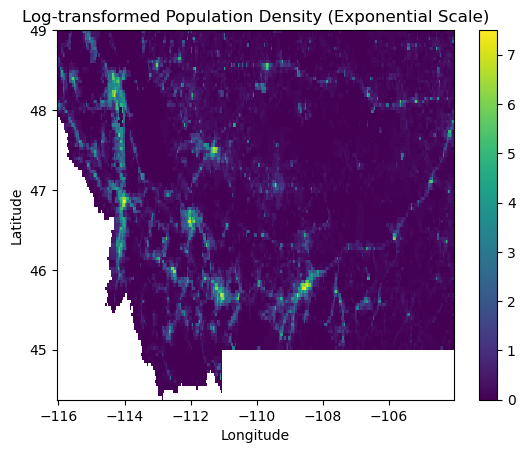

In [60]:
log_pop_data = np.log1p(pop_data)

log_pop_data.plot(cmap='viridis', add_colorbar=True)

plt.title("Log-transformed Population Density (Exponential Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [61]:
#print shapes
print("NDVI Shape:", ndvi_data.shape)
print("Tcomb Shape:", tcomb_data.shape)
print("Rain Shape:", rain_data.shape)
print("Population Data Shape:", log_pop_data.shape)

NDVI Shape: (1, 110, 288)
Tcomb Shape: (1, 112, 288)
Rain Shape: (1, 112, 288)
Population Data Shape: (1, 111, 288)


In [62]:
#check shapes
target_shape = tcomb_data.shape

ndvi_data_resampled = ndvi_data.interp(y=tcomb_data.coords['y'])
log_pop_data_resampled = log_pop_data.interp(y=tcomb_data.coords['y'])
rain_data_resampled = rain_data.interp(y=tcomb_data.coords['y'])

In [63]:
#verify shapes
print("Resampled NDVI Shape:", ndvi_data_resampled.shape)
print("Resampled Population Shape:", log_pop_data_resampled.shape)
print("Resampled Rain Shape:", rain_data_resampled.shape)
print("Tcomb Shape:", tcomb_data.shape)

Resampled NDVI Shape: (1, 112, 288)
Resampled Population Shape: (1, 112, 288)
Resampled Rain Shape: (1, 112, 288)
Tcomb Shape: (1, 112, 288)


In [64]:
#flatten inputs
X2 = np.stack([ndvi_data_resampled.values.flatten(), 
              tcomb_data.values.flatten(), 
              rain_data_resampled.values.flatten()], axis=1)

#flatten y
y2 = log_pop_data_resampled.values.flatten()

#remove NaN becuase they break regression
mask2 = ~np.isnan(y2)
X_train2 = X2[mask2]
y_train2 = y2[mask2]

#ensure shapes
print("X2_train shape:", X_train2.shape)
print("y2_train shape:", y_train2.shape)

#create the model
model2 = RandomForestRegressor(n_estimators=100, random_state=42)

#train the model
model2.fit(X_train2, y_train2)

#predict from training
y_pred2 = model2.predict(X_train2)

print("R^2 Score:", r2_score(y_train2, y_pred2))
print("Number of predictions:", len(y_pred2))

#copy dims of log_p_dens
new_xarray2 = log_pop_data_resampled.copy()

#find not nan locations
non_nan_indices2 = np.where(~np.isnan(log_pop_data_resampled.values))

#assign seqentially through pred since it follows orig pattern
new_xarray2.values[non_nan_indices2] = y_pred2


X2_train shape: (25665, 3)
y2_train shape: (25665,)
R^2 Score: 0.8875699520990729
Number of predictions: 25665


R^2 Score: 0.8875699520990729
Number of predictions: 25665


Text(0.5, 1.0, 'Predicted Population Density')

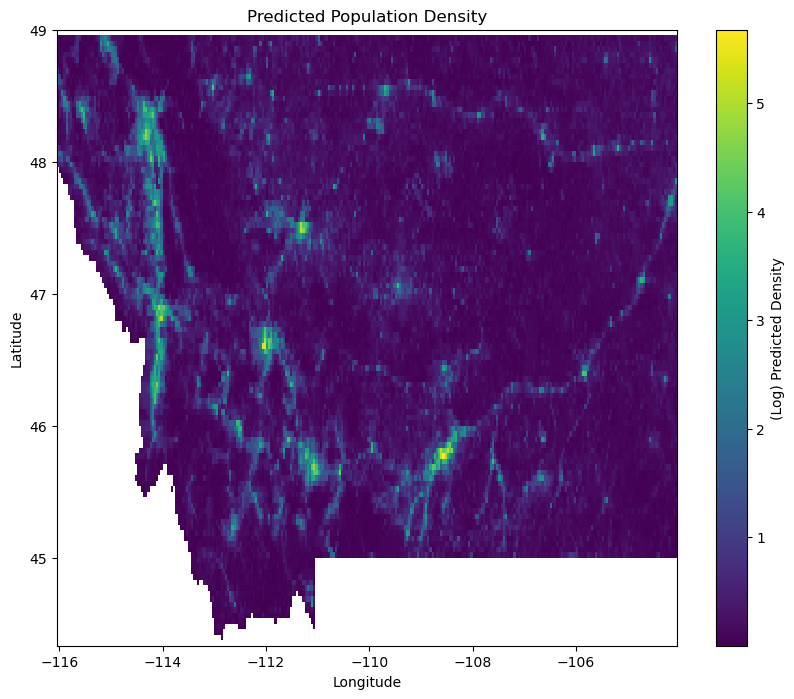

In [65]:
print("R^2 Score:", r2_score(y_train2, y_pred2))
print("Number of predictions:", len(y_pred2))

ax2 = new_xarray2.plot(
    cmap='viridis',
    figsize=(10, 8),
    cbar_kwargs={'label': '(Log) Predicted Density'},
    add_colorbar=True,
)

ax2 = plt.gca()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Predicted Population Density')

So this is much better, but there's a lot less difference to the original than i was expecting. From an aesthetic point of view, could be brighter and scaled correctly. Want to try to add in another dataset that isn't a raster here now. Yes I know this barely counts as a view, maybe a 0.5 view but don't worry there'll be more added. Interestingly is the scale now, the upper limit is lower than the actual density. Hoping that a new dataset will matter more to the random forest--I need a scale for importance.

<h2>View 3: Random Forest Regression 3</h2>

Aquifers: converted from shapefile to raster and follows same resolution and clipping instuctions as above.

In [66]:
import geopandas as gpd
water_path = 'data2\water\PrincipalAquifers_MT.shp'
water_gdf = gpd.read_file(water_path)

print("before:", water_gdf.crs)
water_gdf = water_gdf.to_crs(4269)
print("after:", water_gdf.crs)

before: EPSG:32100
after: EPSG:4269


In [67]:
fitlered_water = water_gdf[
    (water_gdf["hg_name"] != 'Water') &
    (water_gdf["hg_desc"] != 'Includes waterbodies: rivers, streams, lakes, reservoirs, canals, etc.') &
    (water_gdf["hg_type"] == 'In western Montana: Unconfined surficial aquifers with semi-confined to confined aquifers in deep basin-fill. In eastern Montana: generally unconfined.')
]

print(fitlered_water)

    COUNT  FID_1 HG_Code   ID  HG_ID MT_500_hg  \
13    9.0     11      Qs  1.0    1.0        Qs   

                                      hg_name                   hg_age  \
13  Cenozoic Basin Fill and Alluvium Aquifers  Quaternary and Tertiary   

                                              hg_type  ObjectID    Shape_Leng  \
13  In western Montana: Unconfined surficial aquif...         1  9.108728e+07   

      Shape_Le_1    Shape_Area  \
13  9.108728e+07  4.765351e+10   

                                              hg_desc  \
13  Basin-fill aquifers: Western Montana intermont...   

                                             geometry  
13  MULTIPOLYGON (((-112.15645 44.57744, -112.1566...  


<Axes: >

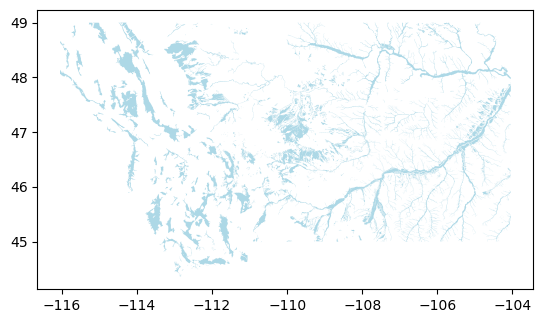

In [68]:
fitlered_water.plot(color='lightblue')

note that was the incoming shapefile, here's what it looks like after qgis:

In [69]:
water = xrio.open_rasterio("data2\water\water_raster_file.tif")

print(water)
water

<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
[32256 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.46 44.42 44.38
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0


<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 129kB
[32256 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.46 44.42 44.38
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

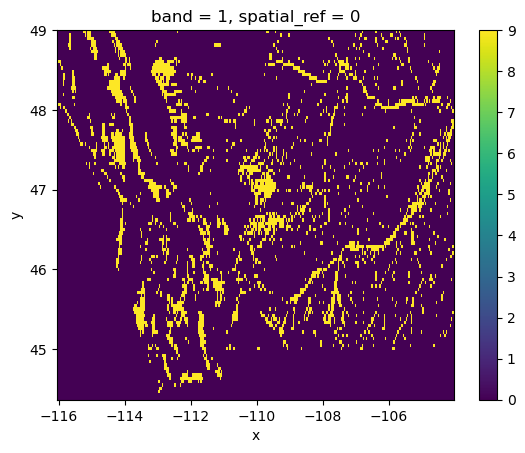

In [70]:
water.plot()

adding water to random forest

In [71]:
print("Aquifer Shape:", water.shape)

water_resampled = water.interp(y=water.coords['y'])

Aquifer Shape: (1, 112, 288)


In [72]:
#you know the drill by now
print("Resampled NDVI Shape:", ndvi_data_resampled.shape)
print("Resampled Population Shape:", log_pop_data_resampled.shape)
print("Resampled Rain Shape:", rain_data_resampled.shape)
print("Resampled Aquifer Shape:", water_resampled.shape)
print("Tcomb Shape:", tcomb_data.shape)

Resampled NDVI Shape: (1, 112, 288)
Resampled Population Shape: (1, 112, 288)
Resampled Rain Shape: (1, 112, 288)
Resampled Aquifer Shape: (1, 112, 288)
Tcomb Shape: (1, 112, 288)


In [73]:
X3 = np.stack([ndvi_data_resampled.values.flatten(), 
              tcomb_data.values.flatten(), 
              rain_data_resampled.values.flatten(),
              water_resampled.values.flatten()], axis=1)

y3 = log_pop_data_resampled.values.flatten()

mask3 = ~np.isnan(y3)
X_train3 = X3[mask3]
y_train3 = y3[mask3]

print("X3_train shape:", X_train3.shape)
print("y3_train shape:", y_train3.shape)

model3 = RandomForestRegressor(n_estimators=100, random_state=42)

model3.fit(X_train3, y_train3)

y_pred3 = model3.predict(X_train3)

print("R^2 Score:", r2_score(y_train3, y_pred3))
print("Number of predictions:", len(y_pred3))

new_xarray3 = log_pop_data_resampled.copy()

non_nan_indices3 = np.where(~np.isnan(log_pop_data_resampled.values))

new_xarray3.values[non_nan_indices3] = y_pred3

print(new_xarray3)

X3_train shape: (25665, 4)
y3_train shape: (25665,)
R^2 Score: 0.8942634400797438
Number of predictions: 25665
<xarray.DataArray (band: 1, y: 112, x: 288)> Size: 258kB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.15039082, 0.02162301, 0.02659353, ..., 0.2252275 ,
         0.1940546 , 0.48191532],
        [0.03300571, 0.02850233, 0.03521195, ..., 0.32144153,
         0.32335806, 0.88830583],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
    spatial_ref  int64 8B 0
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
Attribut

R^2 Score: 0.8942634400797438
Number of predictions: 25665
Feature Importances:
NDVI: 0.3030
Temperature: 0.3441
Rainfall: 0.2737
Aquifers: 0.0793


Text(0.5, 1.0, 'Predicted Population Density')

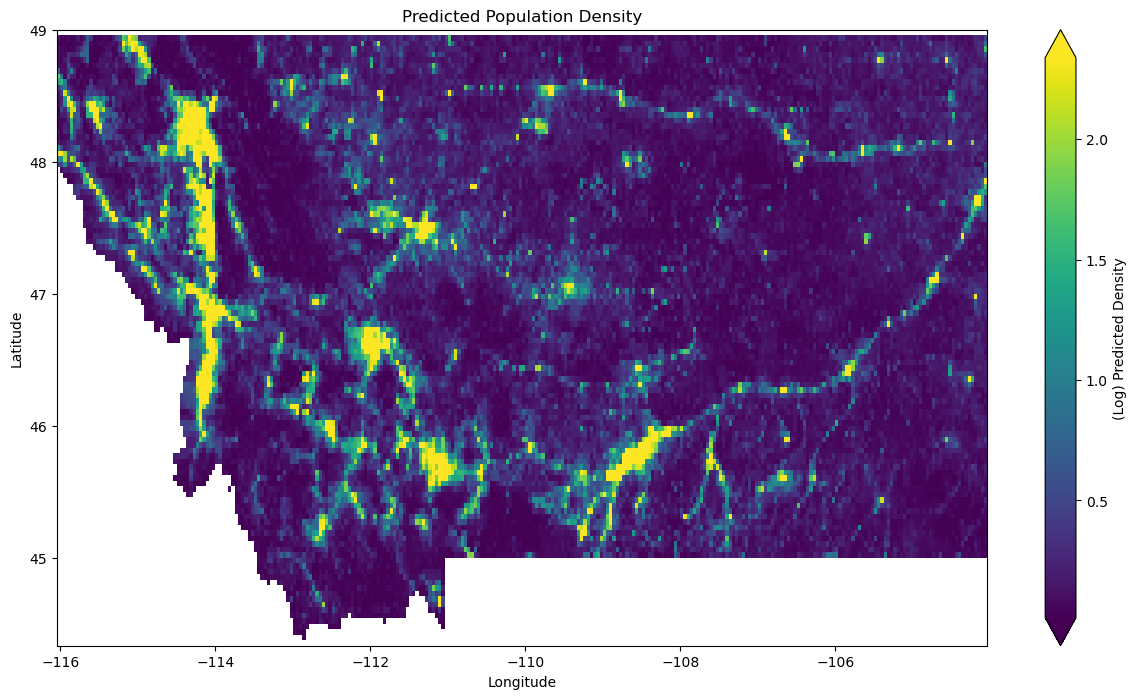

In [74]:
print("R^2 Score:", r2_score(y_train3, y_pred3))
print("Number of predictions:", len(y_pred3))

feat_names3 = ["NDVI", "Temperature", "Rainfall", "Aquifers"]
feature_importances3 = model3.feature_importances_
print("Feature Importances:")
for name, importance in zip(feat_names3, feature_importances3):
    print(f"{name}: {importance:.4f}")
    
ax3 = new_xarray3.plot(
    cmap='viridis',
    figsize=(15, 8),
    cbar_kwargs={'label': '(Log) Predicted Density'},
    robust=True,
    add_colorbar=True,
)

ax3 = plt.gca()
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Predicted Population Density')

Well, plot looks better now. I was genuinely expecting the water to do more but it turns out that it genuinely did not matter much. Making the plot robust definitely helped, but for sure, was kinda underwhelming. To be fair, im training over the entire dataset and then predicting which might cause a problem, maybe if i focus on northwestern montana water will matter more? Glad that the feature importance has a percentage scale now though.

<h2>View 4: Random Forest Regression 4--Training area changes</h2>

train over smaller and specific areas

In [75]:
#smaller training area
left_mask6 = (slice(0, 50), slice(0, 50)) #this controls bounding box

X_left6 = np.stack([ndvi_data_resampled.values[left_mask6].flatten(), 
                         tcomb_data.values[left_mask6].flatten(), 
                         rain_data_resampled.values[left_mask6].flatten(),
                         water_resampled.values[left_mask6].flatten()], axis=1)

y_left6 = log_pop_data_resampled.values[left_mask6].flatten()

In [76]:
mask6_left = ~np.isnan(y_left6)
X_train6_left = X_left6[mask6_left]
y_train6_left = y_left6[mask6_left]

print("X6_train_left_half shape:", X_train6_left.shape)
print("y6_train_left_half shape:", y_train6_left.shape)

X6_train_left_half shape: (13813, 4)
y6_train_left_half shape: (13813,)


In [77]:
#same as normal
model6 = RandomForestRegressor(n_estimators=100, random_state=42)
model6.fit(X_train6_left, y_train6_left)

mask6 = ~np.isnan(log_pop_data_resampled.values)
non_nan_indices6 = np.where(mask6)

X6_full_non_nan = np.stack([ndvi_data_resampled.values[mask6],
                            tcomb_data.values[mask6],
                            rain_data_resampled.values[mask6],
                            water_resampled.values[mask6]], axis=1)

y_pred6_full = model6.predict(X6_full_non_nan)

if len(y_pred6_full) == np.sum(mask6):
    new_xarray6 = log_pop_data_resampled.copy()
    new_xarray6.values[non_nan_indices6] = y_pred6_full
else:
    print("Shape mismatch between predictions and non-NaN locations!")

R^2 Score: 0.44996962969197796
Feature Importances:
NDVI: 0.3091
Temperature: 0.3356
Rainfall: 0.2646
Aquifers: 0.0907


Text(0.5, 1.0, 'Predicted Population Density')

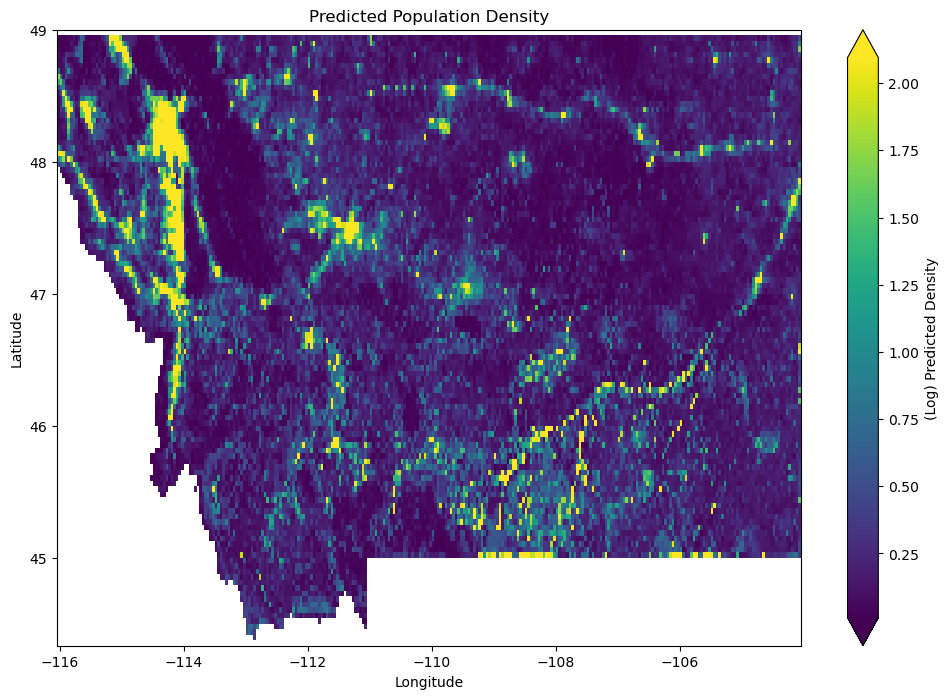

In [78]:
y_true_flat6 = log_pop_data_resampled.values.flatten()
mask6 = ~np.isnan(y_true_flat6) #non nan mask
y_true6 = y_true_flat6[mask6] #non nan values


y_pred_non_nan6 = y_pred6_full

#r2
r2_6 = r2_score(y_true6, y_pred_non_nan6)
print(f"R^2 Score: {r2_6}")

feat_names6 = ["NDVI", "Temperature", "Rainfall", "Aquifers"]
feature_importances6 = model6.feature_importances_
print("Feature Importances:")
for name, importance in zip(feat_names6, feature_importances6):
    print(f"{name}: {importance:.4f}")

# Plot the predicted population density
ax6 = new_xarray6.plot(
    cmap='viridis',
    figsize=(12, 8),
    cbar_kwargs={'label': '(Log) Predicted Density'},
    robust=True,
    add_colorbar=True,
)

ax6 = plt.gca()
ax6.set_xlabel('Longitude')
ax6.set_ylabel('Latitude')
ax6.set_title('Predicted Population Density')

This looks much better, finally getting something unique here. Next iteration will show bounding boxes and plots for more information. The scale is also more descriptive now which is nice but maybe not entirely necessary. Granted, I'm being biased towards aquifers with my placement of the training area and even still it doesn't matter much. Funny that it was what caused me to do the project and its not weighted very high though.

<h2>View 5: Random Forest Regression 5</h2>

In [79]:
left_mask7 = (slice(0, 50), slice(0, 50)) #this controls bounding box
data_shape = log_pop_data_resampled.shape


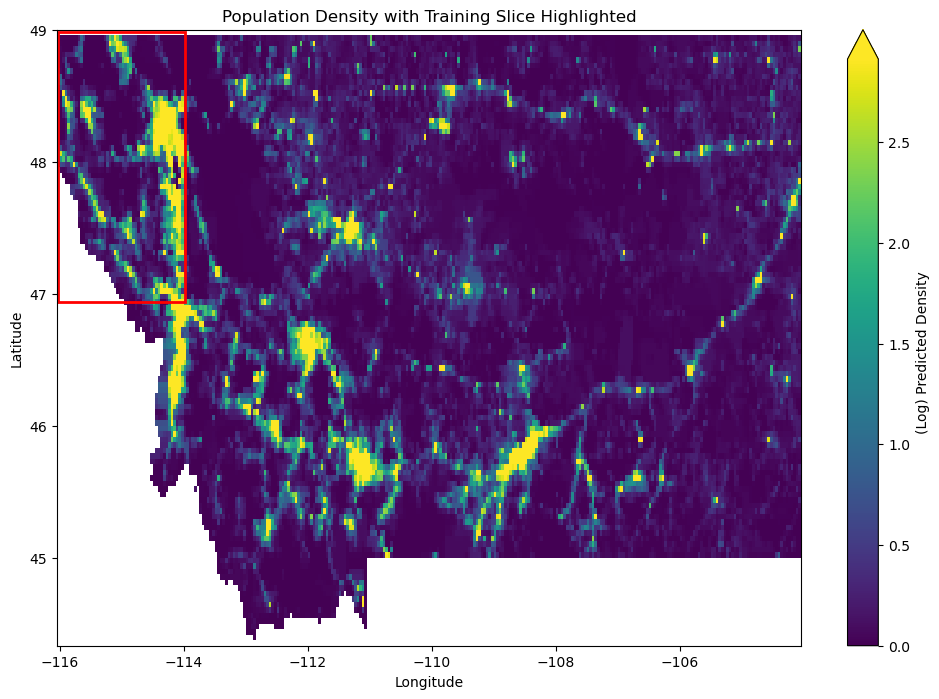

In [80]:
px = log_pop_data_resampled.plot(
    cmap='viridis',
    figsize=(12, 8),
    cbar_kwargs={'label': '(Log) Predicted Density'},
    robust=True,
    add_colorbar=True,
)

#find coords
x_coords = log_pop_data_resampled.coords['x'].values[left_mask7[1]]
y_coords = log_pop_data_resampled.coords['y'].values[left_mask7[0]]

#make box bounds
highlight_x = x_coords.min()
highlight_y = y_coords.min()
highlight_width = x_coords.max() - x_coords.min()
highlight_height = y_coords.max() - y_coords.min()

#add box
rect = Rectangle(
    (highlight_x, highlight_y),
    highlight_width,
    highlight_height,
    linewidth=2,
    edgecolor='red',
    facecolor='none'
)

px = plt.gca()
px.add_patch(rect)

px.set_xlabel('Longitude')
px.set_ylabel('Latitude')
px.set_title('Population Density with Training Slice Highlighted')

plt.show()

In [81]:
X_left7 = np.stack([ndvi_data_resampled.values[left_mask7].flatten(), 
                         tcomb_data.values[left_mask7].flatten(), 
                         rain_data_resampled.values[left_mask7].flatten(),
                         water_resampled.values[left_mask7].flatten()], axis=1)

y_left7 = log_pop_data_resampled.values[left_mask7].flatten()

In [82]:
# Remove NaN values for training
mask7_left = ~np.isnan(y_left7)
X_train7_left = X_left7[mask7_left]
y_train7_left = y_left7[mask7_left]

print("X7_train_left_half shape:", X_train7_left.shape)
print("y7_train_left_half shape:", y_train7_left.shape)

X7_train_left_half shape: (13813, 4)
y7_train_left_half shape: (13813,)


In [83]:
#same thing as always
model7 = RandomForestRegressor(n_estimators=100, random_state=42)
model7.fit(X_train7_left, y_train7_left)

mask7 = ~np.isnan(log_pop_data_resampled.values)
non_nan_indices7 = np.where(mask7)

X7_full = np.stack([ndvi_data_resampled.values[mask7],
                            tcomb_data.values[mask7],
                            rain_data_resampled.values[mask7],
                            water_resampled.values[mask7]], axis=1)

y_pred7_full = model7.predict(X7_full)

print(f"Predictions shape: {y_pred7_full.shape}")
print(f"Number of non-NaN values in target: {np.sum(mask7)}")

new_xarray7 = log_pop_data_resampled.copy()

non_nan_indices7 = np.where(mask7)

if len(y_pred7_full) == np.sum(mask7):
    new_xarray7 = log_pop_data_resampled.copy()
    new_xarray7.values[non_nan_indices7] = y_pred7_full
else:
    print("Shape mismatch between predictions and non-NaN locations!")

Predictions shape: (25665,)
Number of non-NaN values in target: 25665


R^2 Score: 0.44996962969197796
Feature Importances:
NDVI: 0.3091
Temperature: 0.3356
Rainfall: 0.2646
Aquifers: 0.0907


Text(0.5, 1.0, 'Predicted Population Density')

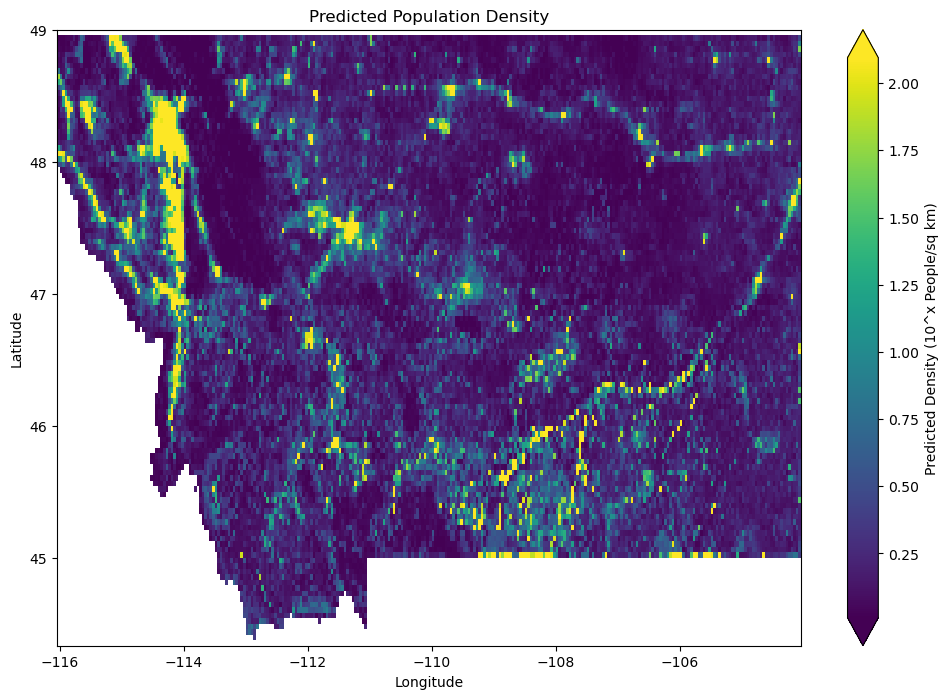

In [98]:
y_true_flat7 = log_pop_data_resampled.values.flatten()
mask7 = ~np.isnan(y_true_flat7) #non nan mask
y_true7 = y_true_flat7[mask7] #non nan values


y_pred_non_nan7 = y_pred7_full

#r2
r2_7 = r2_score(y_true7, y_pred_non_nan7)
print(f"R^2 Score: {r2_7}")

feat_names7 = ["NDVI", "Temperature", "Rainfall", "Aquifers"]
feature_importances7 = model7.feature_importances_
print("Feature Importances:")
for name, importance in zip(feat_names7, feature_importances7):
    print(f"{name}: {importance:.4f}")

# Plot the predicted population density
ax7 = new_xarray7.plot(
    cmap='viridis',
    figsize=(12, 8),
    cbar_kwargs={'label': 'Predicted Density (10^x People/sq km)'},
    robust=True,
    add_colorbar=True,
)

ax7 = plt.gca()
ax7.set_xlabel('Longitude')
ax7.set_ylabel('Latitude')
ax7.set_title('Predicted Population Density')

Apart from the bounding box being shown on the main graph it doesn't matter too much. I view this though as the best 2 picture depiction of my project though from a code point of view. Initially I was planning on just submitting this, it satisfies all the requirements I have, but time to attempt html in 2 hrs. It probably won't show the bounding box... I'm not entirely sure its necessary unless you're looking at how this regression works.

<h2>View 6/7: Folium Plotting</h2>

In [99]:
new_xarray7

<xarray.DataArray 'x7' (band: 1, y: 112, x: 288)> Size: 258kB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.37699336e-02, 5.42747671e-03, 1.59914346e-02, ...,
         2.31090594e-01, 1.75259794e-01, 4.65129865e-01],
        [3.73200572e-02, 1.88696888e-02, 9.01237586e-04, ...,
         2.93782725e-01, 2.94557125e-01, 9.27612705e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
    spatial_ref  int64 8B 0
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
Attributes:
    STATISTICS_MAXIMUM:        1804.8670654297
    STATISTICS_MEAN:           2.9575220193198
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         34.230102647606
    STATISTICS_VALID_PERCENT:  81.25
    _FillValue:                -3.402823e+38
    scale_factor:              1.0
    add_offset:                0.0

In [100]:
import folium
new_xarray7.name = "x7"
print(new_xarray7.name)
df1 = new_xarray7.to_dataframe().reset_index()


x7


In [101]:
df1

,band,y,x,spatial_ref,x7
0,1,48.983333,-116.020833,0,NaN
1,1,48.983333,-115.979167,0,NaN
2,1,48.983333,-115.937500,0,NaN
3,1,48.983333,-115.895833,0,NaN
4,1,48.983333,-115.854167,0,NaN
...,...,...,...,...,...
32251,1,44.358333,-104.229167,0,NaN
32252,1,44.358333,-104.187500,0,NaN
32253,1,44.358333,-104.145833,0,NaN
32254,1,44.358333,-104.104167,0,NaN


In [102]:
new_xarray7

<xarray.DataArray 'x7' (band: 1, y: 112, x: 288)> Size: 258kB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.37699336e-02, 5.42747671e-03, 1.59914346e-02, ...,
         2.31090594e-01, 1.75259794e-01, 4.65129865e-01],
        [3.73200572e-02, 1.88696888e-02, 9.01237586e-04, ...,
         2.93782725e-01, 2.94557125e-01, 9.27612705e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
    spatial_ref  int64 8B 0
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
Attributes:
    STATISTICS_MAXIMUM:        1804.8670654297
    STATISTICS_MEAN:           2.9575220193198
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         34.230102647606
    STATISTICS_VALID_PERCENT:  81.25
    _FillValue:                -3.402823e+38
    scale_factor:              1.0
    add_offset:                0.0

In [103]:
new_xarray8 = new_xarray7.copy()

In [104]:
tiff_file = "output_data.tif"
new_xarray8.rio.write_crs("EPSG:4269", inplace=True)
new_xarray8.rio.to_raster(tiff_file)

In [105]:
new_xarray8

<xarray.DataArray 'x7' (band: 1, y: 112, x: 288)> Size: 258kB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.37699336e-02, 5.42747671e-03, 1.59914346e-02, ...,
         2.31090594e-01, 1.75259794e-01, 4.65129865e-01],
        [3.73200572e-02, 1.88696888e-02, 9.01237586e-04, ...,
         2.93782725e-01, 2.94557125e-01, 9.27612705e-01],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -116.0 -116.0 -115.9 ... -104.1 -104.1 -104.1
  * y            (y) float64 896B 48.98 48.94 48.9 48.86 ... 44.44 44.4 44.36
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_MAXIMUM:        1804.8670654297
    STATISTICS_MEAN:           2.9575220193198
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         34.230102647606
    STATISTICS_VALID_PERCENT:  81.25
    _FillValue:                -3.402823e+38
    scale_factor:              1.0
    add_offset:                0.0

In [106]:
import folium
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from folium.plugins import Draw

# Replace NaNs with zeros and save data as an image
def save_data_as_image(xarray, filename):
    data = xarray.values[0]  # Extract the first band
    data = np.nan_to_num(data, nan=0)  # Replace NaNs with 0
    plt.imsave(filename, data, cmap="viridis")  # Save the image

save_data_as_image(new_xarray7, "fin.png")
save_data_as_image(log_pop_data_resampled, "lpdr.png")
save_data_as_image(ndvi_data_resampled, "ndvire.png")
save_data_as_image(rain_data_resampled, "rdre.png")
save_data_as_image(tcomb_data, "tcomb.png")


# Create compact color bars for each layer with specific scales
def create_color_bar(cmap_name, filename, vmin, vmax):
    fig, ax = plt.subplots(figsize=(4, 0.15))  # Much smaller color bar size, horizontal
    fig.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)
    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal', aspect=30)
    plt.savefig(filename, transparent=True, bbox_inches='tight', pad_inches=0.05)
    plt.close()

# Get the min and max values for each dataset to create accurate color bars
vmin_fin, vmax_fin = new_xarray7.min().item(), new_xarray7.max().item()
vmin_lpdr, vmax_lpdr = log_pop_data_resampled.min().item(), log_pop_data_resampled.max().item()
vmin_ndvire, vmax_ndvire = ndvi_data_resampled.min().item(), ndvi_data_resampled.max().item()
vmin_rdre, vmax_rdre = rain_data_resampled.min().item(), rain_data_resampled.max().item()
vmin_tcomb, vmax_tcomb = tcomb_data.min().item(), tcomb_data.max().item()

# Create color bars for each data layer
create_color_bar("viridis", "colorbar_fin.png", vmin_fin, vmax_fin)
create_color_bar("viridis", "colorbar_lpdr.png", vmin_lpdr, vmax_lpdr)
create_color_bar("viridis", "colorbar_ndvire.png", vmin_ndvire, vmax_ndvire)
create_color_bar("viridis", "colorbar_rdre.png", vmin_rdre, vmax_rdre)
create_color_bar("viridis", "colorbar_tcomb.png", vmin_tcomb, vmax_tcomb)

# Define the geographic bounds (latitude and longitude of the image corners)
lat_min, lat_max = new_xarray7.y.min().item(), new_xarray7.y.max().item()
lon_min, lon_max = new_xarray7.x.min().item(), new_xarray7.x.max().item()
bounds = [[lat_min, lon_min], [lat_max, lon_max]]

# Create the map
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add image overlays to the map
def add_image_overlay_to_map(image_filename, bounds, opacity, name):
    return folium.raster_layers.ImageOverlay(
        image=image_filename,
        bounds=bounds,
        opacity=opacity,
        name=name  # Add a name for the layer, which will appear in the LayerControl
    )

# Add the overlay images with names for toggling
overlay7 = add_image_overlay_to_map("fin.png", bounds, opacity=0.6, name="Predicted Density")
overlay8 = add_image_overlay_to_map("lpdr.png", bounds, opacity=0.6, name="Log Pop Density")
overlay9 = add_image_overlay_to_map("ndvire.png", bounds, opacity=0.6, name="NDVI")
overlay10 = add_image_overlay_to_map("rdre.png", bounds, opacity=0.6, name="Rainfall")
overlay11 = add_image_overlay_to_map("tcomb.png", bounds, opacity=0.6, name="Temperature")

# Add overlays to the map
overlay7.add_to(m)
overlay8.add_to(m)
overlay9.add_to(m)
overlay10.add_to(m)
overlay11.add_to(m)

# Add LayerControl to toggle overlays on and off
folium.LayerControl().add_to(m)

# Add a "Back" button to the map (fixed to top left)
back_button_html = """
    <style>
        .square-button {
            width: 35px;
            height: 35px;
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 16px;
            padding: 0;
            border-radius: 10px;
            background-color: #007bff;
            color: white;
            text-decoration: none;
        }

        .square-button:hover {
            background-color: #0056b3;
        }
    </style>

    <div style="position: fixed; top: 80px; left: 9px; z-index: 1000;">
        <a href="index.html" class="btn square-button">←</a>
    </div>
"""

# Add the "Back" button to the map
m.get_root().html.add_child(folium.Element(back_button_html))

# Create an HTML legend with horizontal color bar images for each layer using flexbox
legend_html = """
<div style="
    position: fixed; 
    top: 10px; left: 50px; right: 65px; 
    background-color: white; padding: 10px; border: 2px solid grey; z-index: 1000;
    display: flex; flex-direction: column; justify-content: flex-start; align-items: center;
    height: auto; width: auto;
    ">
    <h4>Layer Legends</h4>
    <div style="display: flex; flex-wrap: wrap; justify-content: center; gap: 10px;">
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>Pred. Density (10^x People/sq km):<br><img src="colorbar_fin.png" style="width:150px"></p>
        </div>
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>Pop Density (10^x People/sq km):<br><img src="colorbar_lpdr.png" style="width:150px"></p>
        </div>
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>NDVI (Index Value):<br><img src="colorbar_ndvire.png" style="width:150px"></p>
        </div>
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>Rainfall (mm):<br><img src="colorbar_rdre.png" style="width:150px"></p>
        </div>
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>Temperature (F):<br><img src="colorbar_tcomb.png" style="width:150px"></p>
        </div>
    </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map
m.save("overlay_map_with_checkboxes_and_legends_flex.html")


In [109]:
import folium 

data = log_pop_data_resampled.values[0]  # Extract the first band if there's a single time or depth slice

# Replace NaNs with a color (like transparent or zero for simplicity)
data = np.nan_to_num(data, nan=0)

# Save the data as an image (e.g., PNG)
plt.imsave("tempPop_image.png", data, cmap="viridis")

# Define the geographic bounds (latitude and longitude of the image corners)
lat_min, lat_max = log_pop_data_resampled.y.min().item(), log_pop_data_resampled.y.max().item()
lon_min, lon_max = log_pop_data_resampled.x.min().item(), log_pop_data_resampled.x.max().item()
bounds = [[lat_min, lon_min], [lat_max, lon_max]]

# Create a Folium map, centered on the middle of the data
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Overlay the image with specified bounds and optional opacity
folium.raster_layers.ImageOverlay(
    image="tempPop_image.png",
    bounds=bounds,
    opacity=0.6,
).add_to(m)

# Add a "Back" button to the map (fixed to top left)
back_button_html = """
    <style>
        .square-button {
            width: 35px;
            height: 35px;
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 16px;
            padding: 0;
            border-radius: 10px;
            background-color: #007bff;
            color: white;
            text-decoration: none;
        }

        .square-button:hover {
            background-color: #0056b3;
        }
    </style>

    <div style="position: fixed; top: 80px; left: 9px; z-index: 1000;">
        <a href="index.html" class="btn square-button">←</a>
    </div>
"""

# Add the "Back" button to the map
m.get_root().html.add_child(folium.Element(back_button_html))

# Add legend (optional)
legend_html = """
<div style="
    position: fixed; 
    top: 10px; left: 50px; right: 65px; 
    background-color: white; padding: 10px; border: 2px solid grey; z-index: 1000;
    display: flex; flex-direction: column; justify-content: flex-start; align-items: center;
    height: auto; width: auto;
    ">
    <h4>Layer Legends</h4>
    <div style="display: flex; flex-wrap: wrap; justify-content: center; gap: 10px;">
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>Pop Density (10^x People/sq km):<br><img src="colorbar_lpdr.png" style="width:150px"></p>
        </div>
    </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map as an HTML file or display directly
m.save("overlayPop_map.html")

In [108]:
data = new_xarray7.values[0]  # Extract the first band if there's a single time or depth slice

# Replace NaNs with a color (like transparent or zero for simplicity)
data = np.nan_to_num(data, nan=0)

# Save the data as an image (e.g., PNG)
plt.imsave("temp_image.png", data, cmap="viridis")

# Define the geographic bounds (latitude and longitude of the image corners)
lat_min, lat_max = new_xarray7.y.min().item(), new_xarray7.y.max().item()
lon_min, lon_max = new_xarray7.x.min().item(), new_xarray7.x.max().item()
bounds = [[lat_min, lon_min], [lat_max, lon_max]]

# Create a Folium map, centered on the middle of the data
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Overlay the image with specified bounds and optional opacity
folium.raster_layers.ImageOverlay(
    image="temp_image.png",
    bounds=bounds,
    opacity=0.6,
).add_to(m)

# Add a "Back" button to the map (fixed to top left)
back_button_html = """
    <style>
        .square-button {
            width: 35px;
            height: 35px;
            display: flex;
            align-items: center;
            justify-content: center;
            font-size: 16px;
            padding: 0;
            border-radius: 10px;
            background-color: #007bff;
            color: white;
            text-decoration: none;
        }

        .square-button:hover {
            background-color: #0056b3;
        }
    </style>

    <div style="position: fixed; top: 80px; left: 9px; z-index: 1000;">
        <a href="index.html" class="btn square-button">←</a>
    </div>
"""

# Add the "Back" button to the map
m.get_root().html.add_child(folium.Element(back_button_html))

# Add legend (optional)
legend_html = """
<div style="
    position: fixed; 
    top: 10px; left: 50px; right: 65px; 
    background-color: white; padding: 10px; border: 2px solid grey; z-index: 1000;
    display: flex; flex-direction: column; justify-content: flex-start; align-items: center;
    height: auto; width: auto;
    ">
    <h4>Layer Legends</h4>
    <div style="display: flex; flex-wrap: wrap; justify-content: center; gap: 10px;">
        <div style="display: inline-block; margin: 5px; flex: 1;">
            <p>Predicted Density (10^x People/sq km):<br><img src="colorbar_fin.png" style="width:150px"></p>
        </div>
    </div>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
# Save the map as an HTML file or display directly
m.save("overlay_map.html")

I absolutely despise working with html, even with AI help on that its very finnicky. Think I got something that looks visually appealing and follows my data accurately. Allows user to toggle and discover 'better' areas for each input layer. Also allows user to zoom in and identify individual areas of interest. To be fair, I'd much rather work with folium compared to ipyleaflet, I've only seen a little of it and it looks horrifying.

Final Thoughts:

I think from a view perspective this wasn't my best assignment. However, data wise and analysis wise I'm proud of what I learned and created. The first challenge was data, not included in this turn in is a total of 3 different notebooks with different ways of trying to normalize sources. Found out that a combination of qgis and python was the best way to go about this. I avoided raster data in the past and yeah, I definitely understand why I did initially after this project. Think I'm more equipped to deal with it now though. The second hurdle was the Random Forest Regression, that took a while to get used to. Once again its a situation where I'm proud of what I created, but it was more or less trial and error for a couple days to get the regression to work. Then more of a saga to apply it back to a visible format.

Regardless, thank you in particular for pushing me into this project, I never would've gone into this individually. It gave me a lot of confidence for working with raster data more in the future.